# Overview of the Methodology:
The paper proposes a novel framework for zero-shot semantic segmentation (ZSS), which focuses on addressing the adverse effects caused by noisy and outlying training samples of the seen classes. It leverages Bayesian uncertainty estimation to discriminate between representative and noisy samples during training.

# Key components of their approach include:

Pixel-level Learning with Stochastic Binary Cross-Entropy: For pixel-wise prediction.
Image-level Learning with Bayesian Regression: For overall segmentation quality assessment.
Implementation Steps:
1. Preprocessing:
Dataset Preparation: The framework likely requires datasets with images and their corresponding semantic segmentation maps.
Semantic Embeddings: You'll need to generate semantic embeddings for the classes. This could be done using models like word2vec or GloVe.
2. Model Architecture:
Base Network for Feature Extraction: A deep convolutional neural network (e.g., ResNet, VGG) to extract features from images.
Semantic Embedding Integration: Integrate semantic embeddings into the network to create visual-semantic mappings.
Output Layers: Two output branches are required, one for pixel-wise prediction and another for the overall segmentation quality.
3. Uncertainty Estimation:
Stochastic Binary Cross-Entropy: For pixel-level learning, modify the traditional BCE loss to incorporate uncertainty.
Bayesian Regression for Image-level Learning: Use a Laplacian distribution parameterized by the network's outputs to estimate the uncertainty.
4. Training:
Loss Functions: Implement the uncertainty-aware loss functions for pixel-level and image-level learning.
Optimization: Use an optimizer like SGD or Adam to train the model. Regularize the training to avoid overfitting, especially considering the zero-shot learning context.
5. Visualization:
Intermediate Outputs: Visualize the outputs of the network to understand the semantic segmentation results.
Uncertainty Maps: Visualize the uncertainty estimations to see which areas of the image the model is less certain about.
6. Evaluation:
Zero-Shot Learning Evaluation: Test the model on unseen classes to evaluate its zero-shot learning capabilities.
Metrics: Use metrics like mean Intersection-over-Union (mIoU) to assess the segmentation performance.

# Challenges and Considerations:

- Zero-Shot Learning Complexity: The concept of zero-shot learning, especially in semantic segmentation, is challenging due to the absence of training examples for some classes.
- Uncertainty Estimation: Implementing uncertainty estimation within a deep learning model can be complex and requires a solid understanding of Bayesian methods.
- Computational Resources: Training such models with large datasets and complex architectures may require significant computational resources.

# Final Thoughts:

Implementing this paper's methodology requires advanced skills in deep learning, particularly in semantic segmentation and Bayesian methods. The project would likely be iterative, requiring adjustments to the model architecture and training process based on initial results and evaluations.


# Resources and modules used:

###### We used GluonCV and their tutorials for the preprocessing and building models

# Install theses dependencies

In [ ]:
# pip install gluoncv[full] mxnet-cu101 --upgrade
# conda install pytorch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0 pytorch-cuda=11.7 -c pytorch -c nvidia


# Importing libraries

In [1]:
import ade20k
import mxnet as mx
from mxnet import gluon, autograd
import gluoncv

from gluoncv.utils import download, makedirs
from gluoncv.data import ADE20KSegmentation
from mxnet.gluon.data.vision import transforms
from gluoncv.loss import MixSoftmaxCrossEntropyLoss
from gluoncv.data.transforms.presets.segmentation import test_transform
from gluoncv.utils.parallel import *

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import os

# Data Preprocessing

In [2]:
target_dir = 'ADEChallengeData2016Processed'
download_dir = "W:/COMP473/ADEChallengeData2016"#os.path.join(path, 'downloads')


makedirs(os.path.expanduser(target_dir))

try:
    if download_dir is not None:
        os.symlink(download_dir, target_dir)
except:
    pass


download_dataset = False
if download_dataset == True:
    ade20k.download_ade(target_dir, overwrite=False)

#### loading data

In [3]:
train_dataset = ADE20KSegmentation(split='train')
val_dataset = ADE20KSegmentation(split='val')
print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 20210
Validation images: 2000


#### image transform for color normalization

In [4]:
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

In [5]:
trainset = gluoncv.data.ADE20KSegmentation(split='train', transform=input_transform)
valset = gluoncv.data.ADE20KSegmentation(split='val', transform=input_transform)

print('Training images:', len(trainset))
print('Validation images:', len(valset))

batch_size = 8
# dataset and dataloader
# data_kwargs = {'transform': input_transform,
#                'base_size': args.base_size,
#                'crop_size': args.crop_size}
        
# Create Training Loader
train_data = gluon.data.DataLoader(
    trainset, batch_size, shuffle=True, last_batch='rollover',
    num_workers=batch_size)

val_data = gluon.data.DataLoader(
    valset, batch_size, shuffle=True, last_batch='rollover',
    num_workers=batch_size)

Training images: 20210
Validation images: 2000


## Visualize a sample

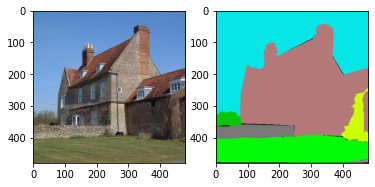

In [6]:
img, mask = val_dataset[0]
# get pallete for the mask
from gluoncv.utils.viz import get_color_pallete
mask = get_color_pallete(mask.asnumpy(), dataset='ade20k')
mask.save('mask.png')

# subplot 1 for img
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(img.asnumpy().astype('uint8'))
# subplot 2 for the mask
mmask = mpimg.imread('mask.png')
fig.add_subplot(1,2,2)
plt.imshow(mmask)
# display
plt.show()

# Model Architecture

## PSPNet Model

In [23]:
from mxnet.gluon import HybridBlock


class _PyramidPooling(HybridBlock):
    def __init__(self, in_channels, **kwargs):
        super(_PyramidPooling, self).__init__()
        out_channels = int(in_channels/4)
        with self.name_scope():
            self.conv1 = _PSP1x1Conv(in_channels, out_channels, **kwargs)
            self.conv2 = _PSP1x1Conv(in_channels, out_channels, **kwargs)
            self.conv3 = _PSP1x1Conv(in_channels, out_channels, **kwargs)
            self.conv4 = _PSP1x1Conv(in_channels, out_channels, **kwargs)

    def pool(self, F, x, size):
        return F.contrib.AdaptiveAvgPooling2D(x, output_size=size)

    def upsample(self, F, x, h, w):
        return F.contrib.BilinearResize2D(x, height=h, width=w)

    def hybrid_forward(self, F, x):
        _, _, h, w = x.shape
        feat1 = self.upsample(F, self.conv1(self.pool(F, x, 1)), h, w)
        feat2 = self.upsample(F, self.conv2(self.pool(F, x, 2)), h, w)
        feat3 = self.upsample(F, self.conv3(self.pool(F, x, 3)), h, w)
        feat4 = self.upsample(F, self.conv4(self.pool(F, x, 4)), h, w)
        return F.concat(x, feat1, feat2, feat3, feat4, dim=1)
    
model = gluoncv.model_zoo.get_psp(dataset='ade20k', backbone='resnet50', pretrained=True)
#model = gluoncv.model_zoo.get_model('psp_resnet101_ade', pretrained=False)

# model = get_segmentation_model(model=args.model, dataset=args.dataset,
#                                backbone=args.backbone, norm_layer=args.norm_layer,
#                                norm_kwargs=args.norm_kwargs, aux=args.aux,
#                                base_size=args.base_size, crop_size=args.crop_size)

print(model)

self.crop_size 480
PSPNet(
  (conv1): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (5): Activation(relu)
    (6): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
  (relu): Activation(relu)
  (maxpool): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (layer1): HybridSequential(
    (0): BottleneckV1b(
      (conv1): Conv2D(128 -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
 

### Costum Model

In [8]:
def build_model(num_classes):
    # Base network for feature extraction (e.g., ResNet, VGG)
    base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False)

    # Adding custom layers for ZSS
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    
    # Pixel-level prediction branch
    pixel_branch = layers.Dense(num_classes, activation='sigmoid')(x)

    # Image-level quality assessment branch
    quality_branch = layers.Dense(1)(x)

    model = models.Model(inputs=base_model.input, outputs=[pixel_branch, quality_branch])
    return model

### DeepLabV3 plus

In [7]:
#ctx = mx.cpu(0)
model = gluoncv.model_zoo.get_model('deeplab_resnet101_ade', pretrained=True)
#net = DataParallelModel(model, ctx)

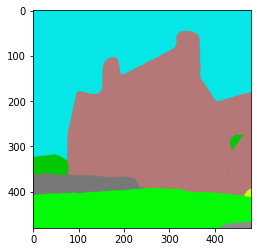

In [9]:
# Quick test;
# make prediction using single scale

output = model.predict(test_transform(img, mx.cpu(0)))
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()


#Add color pallete for visualization
mask = get_color_pallete(predict, 'ade20k')
mask.save('results/output.png')


#show the predicted mask
mmask = mpimg.imread('results/output.png')
plt.imshow(mmask)
plt.show()

# Creating the costum loss function

In [10]:
criterion = MixSoftmaxCrossEntropyLoss(aux=True)

lr_scheduler = gluoncv.utils.LRScheduler(mode='poly', base_lr=0.001,
                                         nepochs=50, iters_per_epoch=len(train_data), power=0.9)

print("Setting training to GPU")

ctx_list = [mx.gpu(0)] #[mx.cpu(0)]
#if net == None:
net = DataParallelModel(model, ctx_list)
criterion = DataParallelCriterion(criterion, ctx_list)

print("Creating the Optimizer")

#kv = mx.kv.create('local')
optimizer = gluon.Trainer(model.collect_params(), 'sgd',
                          {'lr_scheduler': lr_scheduler,
                           'wd':0.0001,
                           'momentum': 0.9,
                           'multi_precision': True})#,
                          #kvstore = kv)

Setting training to GPU
Creating the Optimizer


# Training

In [12]:
from tqdm import tqdm
import shutil

def save_checkpoint(net, args, epoch, mIoU, is_best=False):
    """Save Checkpoint"""
    save_dir = "models"
    filename = 'epoch_%04d_mIoU_%2.4f.params' % (epoch, mIoU)
    filepath = os.path.join(save_dir, filename)
    net.save_parameters(filepath)
    if is_best:
        shutil.copyfile(filename, os.path.join(save_dir, 'model_best.params'))
        
tbar = tqdm(train_data)
train_loss = 0.0
epoch = 10

for i, (data, target) in enumerate(tbar):
    with autograd.record(True):
        outputs =net(data)
        losses = criterion(outputs, target)
        mx.nd.waitall()
        autograd.backward(losses)
    optimizer.step(batch_size)
    for loss in losses:
        train_loss += np.mean(loss.asnumpy()) / len(losses)
    tbar.set_description('Epoch %d, training loss %.3f' % \
        (epoch, train_loss/(i+1)))
    if i %150==0 :
        print('Epoch %d iteration %04d/%04d: training loss %.3f' % \
            (epoch, i, len(train_data), train_loss/(i+1)))
        save_checkpoint(net.module, epoch, 0, True)
    mx.nd.waitall()


    

  0%|                                                                                         | 0/2526 [01:00<?, ?it/s]


KeyboardInterrupt: 

In [16]:
train_loss = 0.0
steps = 500
try:
    for i, (data, target) in enumerate(train_data):
        with autograd.record(True):
            outputs = net(data) # model
            losses = criterion(outputs, target)
            mx.nd.waitall()
            autograd.backward(losses)
        optimizer.step(batch_size)
        for loss in losses:
            train_loss += loss.asnumpy()[0] / len(losses)
        print('Epoch %d, batch %d, training loss %.3f'%(epoch, i, train_loss/(i+1)))
        save_checkpoint(net.module, epoch, 0, True)
        # just demo for 2 iters
        if i > steps:
            save_checkpoint(net.module, epoch, 0, True)
except Exception as e:
    print(e)
    save_checkpoint(net.module, epoch, 0, True)
    

Epoch 10, batch 0, training loss 2.993
Epoch 10, batch 1, training loss 3.076
Epoch 10, batch 2, training loss 3.098
Epoch 10, batch 3, training loss 3.754
Epoch 10, batch 4, training loss 3.893
Epoch 10, batch 5, training loss 3.695
Epoch 10, batch 6, training loss 3.642
Epoch 10, batch 7, training loss 3.610
Epoch 10, batch 8, training loss 3.463
Epoch 10, batch 9, training loss 3.480
Epoch 10, batch 10, training loss 3.530
Epoch 10, batch 11, training loss 3.540
Epoch 10, batch 12, training loss 3.536
Epoch 10, batch 13, training loss 3.549
Epoch 10, batch 14, training loss 3.406
Epoch 10, batch 15, training loss 3.398
Epoch 10, batch 16, training loss 3.381
Epoch 10, batch 17, training loss 3.371
Epoch 10, batch 18, training loss 3.416
Epoch 10, batch 19, training loss 3.390
Epoch 10, batch 20, training loss 3.432
Epoch 10, batch 21, training loss 3.521
Epoch 10, batch 22, training loss 3.545
Epoch 10, batch 23, training loss 3.432
Epoch 10, batch 24, training loss 3.503
Epoch 10, 

Epoch 10, batch 203, training loss 3.319
Epoch 10, batch 204, training loss 3.318
Epoch 10, batch 205, training loss 3.319
Epoch 10, batch 206, training loss 3.328
Epoch 10, batch 207, training loss 3.330
Epoch 10, batch 208, training loss 3.321
Epoch 10, batch 209, training loss 3.318
Epoch 10, batch 210, training loss 3.329
Epoch 10, batch 211, training loss 3.340
Epoch 10, batch 212, training loss 3.341
Epoch 10, batch 213, training loss 3.340
Epoch 10, batch 214, training loss 3.332
Epoch 10, batch 215, training loss 3.333
Epoch 10, batch 216, training loss 3.335
Epoch 10, batch 217, training loss 3.328
Epoch 10, batch 218, training loss 3.328
Epoch 10, batch 219, training loss 3.333
Epoch 10, batch 220, training loss 3.334
Epoch 10, batch 221, training loss 3.335
Epoch 10, batch 222, training loss 3.336
Epoch 10, batch 223, training loss 3.340
Epoch 10, batch 224, training loss 3.336
Epoch 10, batch 225, training loss 3.335
Epoch 10, batch 226, training loss 3.347
Epoch 10, batch 

Epoch 10, batch 403, training loss 3.290
Epoch 10, batch 404, training loss 3.288
Epoch 10, batch 405, training loss 3.286
Epoch 10, batch 406, training loss 3.280
Epoch 10, batch 407, training loss 3.282
Epoch 10, batch 408, training loss 3.284
Epoch 10, batch 409, training loss 3.289
Epoch 10, batch 410, training loss 3.289
Epoch 10, batch 411, training loss 3.284
Epoch 10, batch 412, training loss 3.279
Epoch 10, batch 413, training loss 3.283
Epoch 10, batch 414, training loss 3.281
Epoch 10, batch 415, training loss 3.283
Epoch 10, batch 416, training loss 3.290
Epoch 10, batch 417, training loss 3.285
Epoch 10, batch 418, training loss 3.282
Epoch 10, batch 419, training loss 3.281
Epoch 10, batch 420, training loss 3.277
Epoch 10, batch 421, training loss 3.280
Epoch 10, batch 422, training loss 3.277
Epoch 10, batch 423, training loss 3.277
Epoch 10, batch 424, training loss 3.276
Epoch 10, batch 425, training loss 3.273
Epoch 10, batch 426, training loss 3.273
Epoch 10, batch 

Epoch 10, batch 603, training loss 3.238
Epoch 10, batch 604, training loss 3.234
Epoch 10, batch 605, training loss 3.237
Epoch 10, batch 606, training loss 3.238
Epoch 10, batch 607, training loss 3.238
Epoch 10, batch 608, training loss 3.241
Epoch 10, batch 609, training loss 3.238
Epoch 10, batch 610, training loss 3.238
Epoch 10, batch 611, training loss 3.240
Epoch 10, batch 612, training loss 3.241
Epoch 10, batch 613, training loss 3.240
Epoch 10, batch 614, training loss 3.238
Epoch 10, batch 615, training loss 3.241
Epoch 10, batch 616, training loss 3.243
Epoch 10, batch 617, training loss 3.243
Epoch 10, batch 618, training loss 3.245
Epoch 10, batch 619, training loss 3.244
Epoch 10, batch 620, training loss 3.242
Epoch 10, batch 621, training loss 3.239
Epoch 10, batch 622, training loss 3.236
Epoch 10, batch 623, training loss 3.236
Epoch 10, batch 624, training loss 3.233
Epoch 10, batch 625, training loss 3.235
Epoch 10, batch 626, training loss 3.237
Epoch 10, batch 

Epoch 10, batch 803, training loss 3.231
Epoch 10, batch 804, training loss 3.227
Epoch 10, batch 805, training loss 3.228
Epoch 10, batch 806, training loss 3.229
Epoch 10, batch 807, training loss 3.226
Epoch 10, batch 808, training loss 3.224
Epoch 10, batch 809, training loss 3.223
Epoch 10, batch 810, training loss 3.223
Epoch 10, batch 811, training loss 3.223
Epoch 10, batch 812, training loss 3.221
Epoch 10, batch 813, training loss 3.219
Epoch 10, batch 814, training loss 3.216
Epoch 10, batch 815, training loss 3.217
Epoch 10, batch 816, training loss 3.214
Epoch 10, batch 817, training loss 3.214
Epoch 10, batch 818, training loss 3.213
Epoch 10, batch 819, training loss 3.214
Epoch 10, batch 820, training loss 3.217
Epoch 10, batch 821, training loss 3.218
Epoch 10, batch 822, training loss 3.221
Epoch 10, batch 823, training loss 3.221
Epoch 10, batch 824, training loss 3.221
Epoch 10, batch 825, training loss 3.219
Epoch 10, batch 826, training loss 3.221
Epoch 10, batch 

Epoch 10, batch 1003, training loss 3.206
Epoch 10, batch 1004, training loss 3.208
Epoch 10, batch 1005, training loss 3.209
Epoch 10, batch 1006, training loss 3.210
Epoch 10, batch 1007, training loss 3.211
Epoch 10, batch 1008, training loss 3.210
Epoch 10, batch 1009, training loss 3.208
Epoch 10, batch 1010, training loss 3.208
Epoch 10, batch 1011, training loss 3.208
Epoch 10, batch 1012, training loss 3.209
Epoch 10, batch 1013, training loss 3.209
Epoch 10, batch 1014, training loss 3.209
Epoch 10, batch 1015, training loss 3.210
Epoch 10, batch 1016, training loss 3.212
Epoch 10, batch 1017, training loss 3.211
Epoch 10, batch 1018, training loss 3.210
Epoch 10, batch 1019, training loss 3.210
Epoch 10, batch 1020, training loss 3.211
Epoch 10, batch 1021, training loss 3.211
Epoch 10, batch 1022, training loss 3.211
Epoch 10, batch 1023, training loss 3.211
Epoch 10, batch 1024, training loss 3.211
Epoch 10, batch 1025, training loss 3.209
Epoch 10, batch 1026, training los

Epoch 10, batch 1199, training loss 3.218
Epoch 10, batch 1200, training loss 3.218
Epoch 10, batch 1201, training loss 3.216
Epoch 10, batch 1202, training loss 3.214
Epoch 10, batch 1203, training loss 3.214
Epoch 10, batch 1204, training loss 3.215
Epoch 10, batch 1205, training loss 3.216
Epoch 10, batch 1206, training loss 3.214
Epoch 10, batch 1207, training loss 3.213
Epoch 10, batch 1208, training loss 3.214
Epoch 10, batch 1209, training loss 3.214
Epoch 10, batch 1210, training loss 3.214
Epoch 10, batch 1211, training loss 3.212
Epoch 10, batch 1212, training loss 3.210
Epoch 10, batch 1213, training loss 3.210
Epoch 10, batch 1214, training loss 3.211
Epoch 10, batch 1215, training loss 3.211
Epoch 10, batch 1216, training loss 3.212
Epoch 10, batch 1217, training loss 3.214
Epoch 10, batch 1218, training loss 3.215
Epoch 10, batch 1219, training loss 3.215
Epoch 10, batch 1220, training loss 3.216
Epoch 10, batch 1221, training loss 3.215
Epoch 10, batch 1222, training los

Epoch 10, batch 1395, training loss 3.223
Epoch 10, batch 1396, training loss 3.221
Epoch 10, batch 1397, training loss 3.222
Epoch 10, batch 1398, training loss 3.223
Epoch 10, batch 1399, training loss 3.225
Epoch 10, batch 1400, training loss 3.224
Epoch 10, batch 1401, training loss 3.224
Epoch 10, batch 1402, training loss 3.224
Epoch 10, batch 1403, training loss 3.224
Epoch 10, batch 1404, training loss 3.223
Epoch 10, batch 1405, training loss 3.221
Epoch 10, batch 1406, training loss 3.220
Epoch 10, batch 1407, training loss 3.221
Epoch 10, batch 1408, training loss 3.220
Epoch 10, batch 1409, training loss 3.220
Epoch 10, batch 1410, training loss 3.220
Epoch 10, batch 1411, training loss 3.221
Epoch 10, batch 1412, training loss 3.222
Epoch 10, batch 1413, training loss 3.222
Epoch 10, batch 1414, training loss 3.222
Epoch 10, batch 1415, training loss 3.223
Epoch 10, batch 1416, training loss 3.223
Epoch 10, batch 1417, training loss 3.225
Epoch 10, batch 1418, training los

Epoch 10, batch 1591, training loss 3.223
Epoch 10, batch 1592, training loss 3.223
Epoch 10, batch 1593, training loss 3.226
Epoch 10, batch 1594, training loss 3.226
Epoch 10, batch 1595, training loss 3.226
Epoch 10, batch 1596, training loss 3.227
Epoch 10, batch 1597, training loss 3.228
Epoch 10, batch 1598, training loss 3.229
Epoch 10, batch 1599, training loss 3.230
Epoch 10, batch 1600, training loss 3.230
Epoch 10, batch 1601, training loss 3.229
Epoch 10, batch 1602, training loss 3.229
Epoch 10, batch 1603, training loss 3.229
Epoch 10, batch 1604, training loss 3.229
Epoch 10, batch 1605, training loss 3.229
Epoch 10, batch 1606, training loss 3.229
Epoch 10, batch 1607, training loss 3.229
Epoch 10, batch 1608, training loss 3.227
Epoch 10, batch 1609, training loss 3.227
Epoch 10, batch 1610, training loss 3.226
Epoch 10, batch 1611, training loss 3.227
Epoch 10, batch 1612, training loss 3.227
Epoch 10, batch 1613, training loss 3.226
Epoch 10, batch 1614, training los

Epoch 10, batch 1787, training loss 3.240
Epoch 10, batch 1788, training loss 3.239
Epoch 10, batch 1789, training loss 3.238
Epoch 10, batch 1790, training loss 3.239
Epoch 10, batch 1791, training loss 3.238
Epoch 10, batch 1792, training loss 3.238
Epoch 10, batch 1793, training loss 3.238
Epoch 10, batch 1794, training loss 3.237
Epoch 10, batch 1795, training loss 3.237
Epoch 10, batch 1796, training loss 3.237
Epoch 10, batch 1797, training loss 3.237
Epoch 10, batch 1798, training loss 3.237
Epoch 10, batch 1799, training loss 3.237
Epoch 10, batch 1800, training loss 3.236
Epoch 10, batch 1801, training loss 3.235
Epoch 10, batch 1802, training loss 3.234
Epoch 10, batch 1803, training loss 3.234
Epoch 10, batch 1804, training loss 3.233
Epoch 10, batch 1805, training loss 3.233
Epoch 10, batch 1806, training loss 3.233
Epoch 10, batch 1807, training loss 3.234
Epoch 10, batch 1808, training loss 3.235
Epoch 10, batch 1809, training loss 3.237
Epoch 10, batch 1810, training los

Epoch 10, batch 1983, training loss 3.237
Epoch 10, batch 1984, training loss 3.236
Epoch 10, batch 1985, training loss 3.237
Epoch 10, batch 1986, training loss 3.236
Epoch 10, batch 1987, training loss 3.235
Epoch 10, batch 1988, training loss 3.236
Epoch 10, batch 1989, training loss 3.237
Epoch 10, batch 1990, training loss 3.239
Epoch 10, batch 1991, training loss 3.238
Epoch 10, batch 1992, training loss 3.239
Epoch 10, batch 1993, training loss 3.239
Epoch 10, batch 1994, training loss 3.239
Epoch 10, batch 1995, training loss 3.239
Epoch 10, batch 1996, training loss 3.238
Epoch 10, batch 1997, training loss 3.238
Epoch 10, batch 1998, training loss 3.238
Epoch 10, batch 1999, training loss 3.238
Epoch 10, batch 2000, training loss 3.237
Epoch 10, batch 2001, training loss 3.237
Epoch 10, batch 2002, training loss 3.237
Epoch 10, batch 2003, training loss 3.237
Epoch 10, batch 2004, training loss 3.237
Epoch 10, batch 2005, training loss 3.238
Epoch 10, batch 2006, training los

Epoch 10, batch 2179, training loss 3.246
Epoch 10, batch 2180, training loss 3.245
Epoch 10, batch 2181, training loss 3.245
Epoch 10, batch 2182, training loss 3.245
Epoch 10, batch 2183, training loss 3.244
Epoch 10, batch 2184, training loss 3.244
Epoch 10, batch 2185, training loss 3.246
Epoch 10, batch 2186, training loss 3.247
Epoch 10, batch 2187, training loss 3.247
Epoch 10, batch 2188, training loss 3.247
Epoch 10, batch 2189, training loss 3.248
Epoch 10, batch 2190, training loss 3.248
Epoch 10, batch 2191, training loss 3.249
Epoch 10, batch 2192, training loss 3.248
Epoch 10, batch 2193, training loss 3.249
Epoch 10, batch 2194, training loss 3.248
Epoch 10, batch 2195, training loss 3.249
Epoch 10, batch 2196, training loss 3.250
Epoch 10, batch 2197, training loss 3.251
Epoch 10, batch 2198, training loss 3.252
Epoch 10, batch 2199, training loss 3.252
Epoch 10, batch 2200, training loss 3.252
Epoch 10, batch 2201, training loss 3.252
Epoch 10, batch 2202, training los

KeyboardInterrupt: 

In [ ]:
# 353 data base 4 credits
# ENGR 411 writing docs 
# 
# 

In [17]:
# Save model
save_checkpoint(net.module, 1, 1, True)

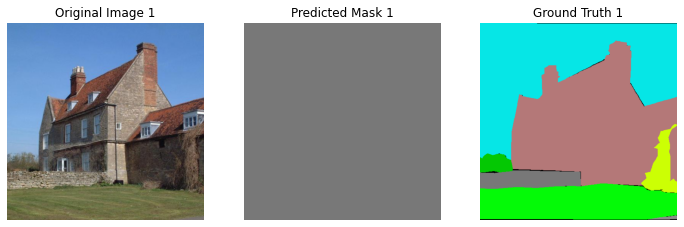

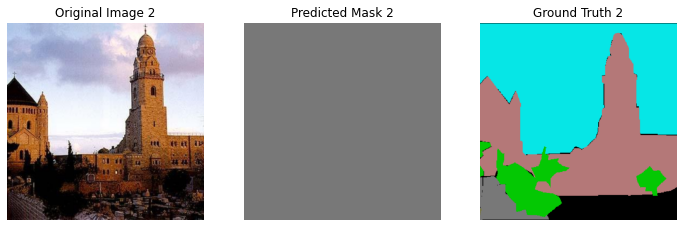

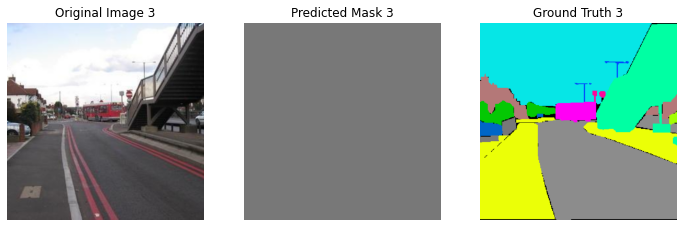

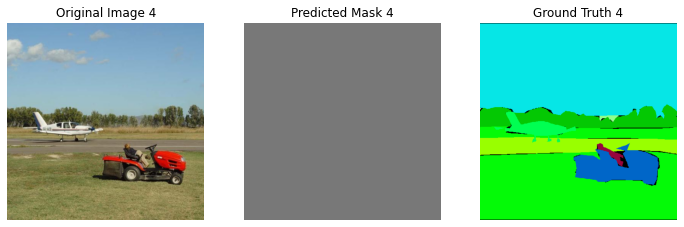

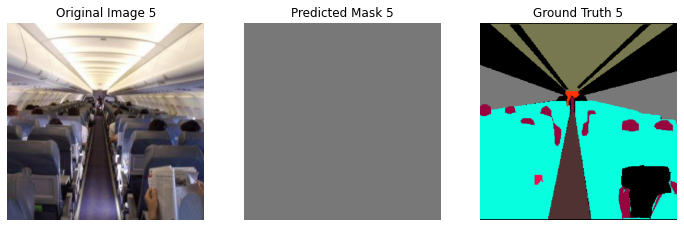

In [18]:

def predict_img(img, ctx_list):
    ctx = ctx_list[0]

    img, mask = val_dataset[0]

    img_test = test_transform(img, ctx)

    output = model.predict(img_test)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

    mask = get_color_pallete(predict, 'ade20k')
    
    return mask

# Process the first 5 images
for i in range(5):
    img, ground_truth = val_dataset[i]

    # Convert img to batched format
    batched_img = img.expand_dims(axis=0)

    # Get the predicted mask
    predicted_mask = predict_img(batched_img, ctx_list)
    predicted_mask.save(f'results/predicted_mask_{i}.png')
    predicted_mask_img = mpimg.imread(f'results/predicted_mask_{i}.png')
    
    # Get palette for the original mask
    original_mask = get_color_pallete(ground_truth.asnumpy(), dataset='ade20k')
    original_mask.save(f'results/original_mask_{i}.png')
    
    original_mask_img = mpimg.imread(f'results/original_mask_{i}.png')

    # Create subplot for each image and its mask
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    # Subplot for the original image
    ax[0].imshow(img.asnumpy().astype('uint8'))
    ax[0].set_title(f"Original Image {i+1}")
    ax[0].axis('off')

    # Subplot for the predicted mask
    ax[1].imshow(predicted_mask_img)
    ax[1].set_title(f"Predicted Mask {i+1}")
    ax[1].axis('off')

    # Subplot for the predicted mask
    ax[2].imshow(original_mask_img)
    ax[2].set_title(f"Ground Truth {i+1}")
    ax[2].axis('off')

    
    # Display the plots
    plt.show()

# Visualization and Evaluation

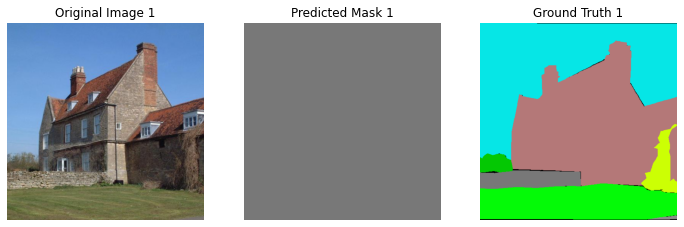

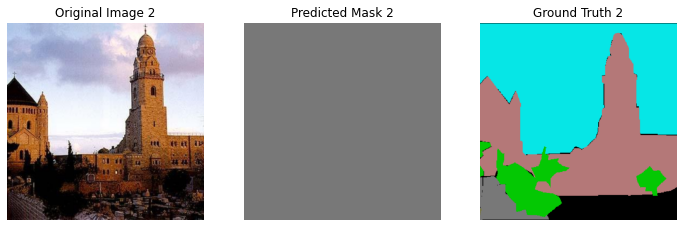

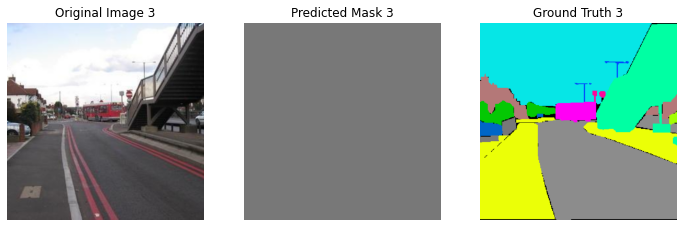

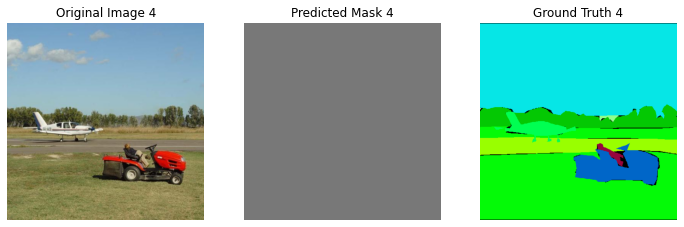

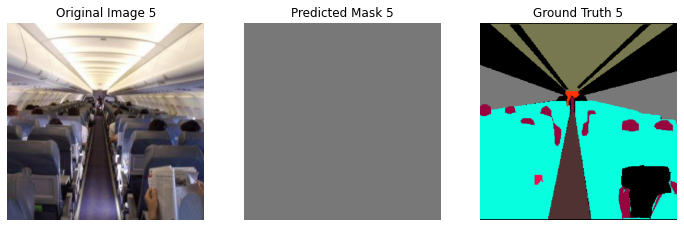

In [19]:
from gluoncv.data.transforms.presets.segmentation import test_transform

def predict_img(img, ctx_list):
    ctx = ctx_list[0]

    img, mask = val_dataset[0]

    img_test = test_transform(img, ctx)

    output = model.predict(img_test)
    predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

    mask = get_color_pallete(predict, 'ade20k')
    
    return mask

# Process the first 5 images
for i in range(5):
    img, ground_truth = val_dataset[i]

    # Convert img to batched format
    batched_img = img.expand_dims(axis=0)

    # Get the predicted mask
    predicted_mask = predict_img(batched_img, ctx_list)
    predicted_mask.save(f'results/predicted_mask_{i}.png')
    predicted_mask_img = mpimg.imread(f'results/predicted_mask_{i}.png')
    
    # Get palette for the original mask
    original_mask = get_color_pallete(ground_truth.asnumpy(), dataset='ade20k')
    original_mask.save(f'results/original_mask_{i}.png')
    
    original_mask_img = mpimg.imread(f'results/original_mask_{i}.png')

    # Create subplot for each image and its mask
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))

    # Subplot for the original image
    ax[0].imshow(img.asnumpy().astype('uint8'))
    ax[0].set_title(f"Original Image {i+1}")
    ax[0].axis('off')

    # Subplot for the predicted mask
    ax[1].imshow(predicted_mask_img)
    ax[1].set_title(f"Predicted Mask {i+1}")
    ax[1].axis('off')

    # Subplot for the predicted mask
    ax[2].imshow(original_mask_img)
    ax[2].set_title(f"Ground Truth {i+1}")
    ax[2].axis('off')

    
    # Display the plots
    plt.show()